In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.express as px
import plotly.figure_factory as ff
import prophet
from prophet import Prophet
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

%matplotlib inline

In [25]:
data = pd.read_csv('sales_data_sample.csv', engine='python', encoding="cp1252")   #ohne encoding cp1251 bekommt man Fehler
data.head(6)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
5,10168,36,96.66,1,3479.76,10/28/2003 0:00,Shipped,4,10,2003,...,9408 Furth Circle,NaN,Burlingame,CA,94217,USA,NaN,Hirano,Juri,Medium


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [27]:
data = data.drop(columns=['ADDRESSLINE2','STATE','POSTALCODE','TERRITORY'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  CITY              2823 non-null   object 


In [35]:
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

In [41]:
df = data[['ORDERDATE','SALES']]
df = df.sort_values(by='ORDERDATE')
df = df.reset_index().drop(columns='index')
df.head()

,ORDERDATE,SALES
0,2003-01-06,5151.00
1,2003-01-06,3390.00
2,2003-01-06,1903.22
3,2003-01-06,1689.03
4,2003-01-09,1404.00


<AxesSubplot:xlabel='ORDERDATE'>

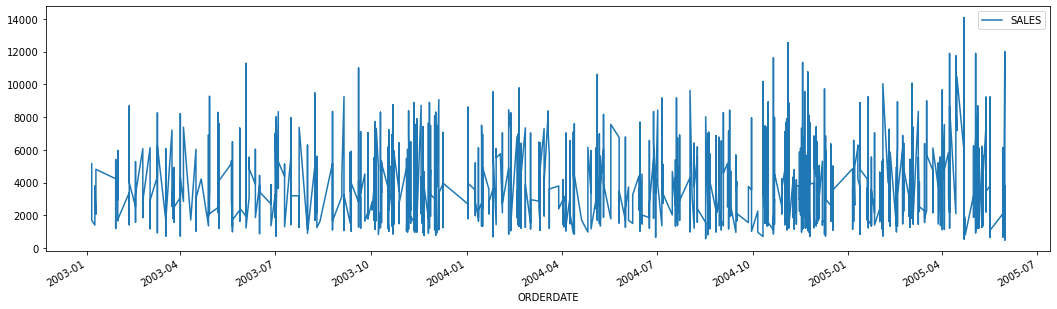

In [52]:
df.plot('ORDERDATE','SALES',figsize=(18, 5))

In [ ]:
df = df.sort_values(by='Year')
df

In [ ]:
df.describe()

In [ ]:
df.values